In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# File paths
data_dir = "/kaggle/input/shopee-product-matching"
train_path = f"{data_dir}/train.csv"
test_path = f"{data_dir}/test.csv"
submission_path = f"{data_dir}/sample_submission.csv"
train_images_dir = f"{data_dir}/train_images"
test_images_dir = f"{data_dir}/test_images"

# Load datasets
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
submission_df = pd.read_csv(submission_path)

# Display first few rows
print("Train Data:")
display(train_df.head())

print("Test Data:")
display(test_df.head())

print("Submission Sample:")
display(submission_df.head())

# Check dataset info
print("\nTrain Data Info:")
print(train_df.info())

print("\nTest Data Info:")
print(test_df.info())

# Create list of full image paths
train_images = [os.path.join(train_images_dir, img) for img in train_df["image"]]
test_images = [os.path.join(test_images_dir, img) for img in test_df["image"]]

Train Data:


,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069


Test Data:


,posting_id,image,image_phash,title
0,test_2255846744,0006c8e5462ae52167402bac1c2e916e.jpg,ecc292392dc7687a,Edufuntoys - CHARACTER PHONE ada lampu dan mus...
1,test_3588702337,0007585c4d0f932859339129f709bfdc.jpg,e9968f60d2699e2c,(Beli 1 Free Spatula) Masker Komedo | Blackhea...
2,test_4015706929,0008377d3662e83ef44e1881af38b879.jpg,ba81c17e3581cabe,READY Lemonilo Mie instant sehat kuah dan goreng


Submission Sample:


,posting_id,matches
0,test_2255846744,test_2255846744
1,test_3588702337,test_3588702337
2,test_4015706929,test_4015706929



Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34250 entries, 0 to 34249
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   posting_id   34250 non-null  object
 1   image        34250 non-null  object
 2   image_phash  34250 non-null  object
 3   title        34250 non-null  object
 4   label_group  34250 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.3+ MB
None

Test Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   posting_id   3 non-null      object
 1   image        3 non-null      object
 2   image_phash  3 non-null      object
 3   title        3 non-null      object
dtypes: object(4)
memory usage: 224.0+ bytes
None


In [ ]:
!pip install timm transformers faiss-gpu

In [ ]:
import os
import torch
import timm
import numpy as np
import pandas as pd
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from transformers import DistilBertTokenizer, DistilBertModel, AlbertTokenizer, AlbertModel, AutoTokenizer, AutoModel
from sklearn.feature_extraction.text import TfidfVectorizer
import faiss
import transformers
from sklearn.neighbors import NearestNeighbors
from torchvision import transforms


In [ ]:
# Check for missing values
print("\nMissing Values in Train Data:")
print(train_df.isnull().sum())

print("\nMissing Values in Test Data:")
print(test_df.isnull().sum())

# Check unique label groups
print("\nUnique Label Groups in Train Data:")
print(train_df["label_group"].nunique())

# Check data distribution
print("\nValue Counts for Label Groups:")
print(train_df["label_group"].value_counts().head(10))



Missing Values in Train Data:
posting_id     0
image          0
image_phash    0
title          0
label_group    0
dtype: int64

Missing Values in Test Data:
posting_id     0
image          0
image_phash    0
title          0
dtype: int64

Unique Label Groups in Train Data:
11014

Value Counts for Label Groups:
label_group
562358068     51
994676122     51
3113678103    51
3627744656    51
159351600     51
1163569239    51
1141798720    51
3206118280    49
1166650192    46
1733221456    46
Name: count, dtype: int64


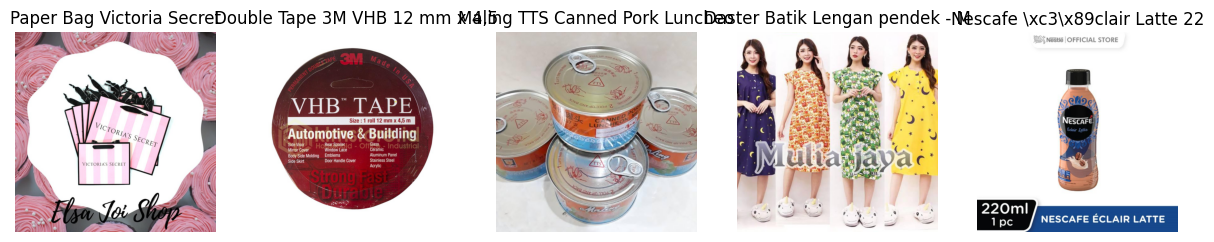

In [ ]:
import matplotlib.pyplot as plt
import cv2
import os

# Function to display sample images
def plot_sample_images(df, data_dir, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        img_path = os.path.join(data_dir, "train_images", df.iloc[i]["image"])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(df.iloc[i]["title"][:30])  # Show truncated title
    plt.show()

# Display sample images
plot_sample_images(train_df, data_dir)


In [ ]:
# Enable GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# Load pre-extracted image features
image_features_nfnet_train = np.load("/kaggle/input/image-features-dataset/nfnet_features_train.npy")
image_features_swin_train = np.load("/kaggle/input/image-features-dataset/swin_features_train.npy")
image_features_efficientnet_train = np.load("/kaggle/input/image-features-dataset/efficientnet_features_train.npy")

print("✅ Features loaded successfully!")


✅ Features loaded successfully!


In [ ]:
# Image Transformation
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
class NFNetExtractor:
    def __init__(self):
        self.model = timm.create_model("nfnet_f0", pretrained=False, num_classes=0).eval().to(device)

    def extract(self, images):
        with torch.no_grad():
            features = self.model(images.to(device)).cpu().numpy()
        return features

In [ ]:
class SwinTransformerExtractor:
    def __init__(self):
        self.model = timm.create_model("swin_base_patch4_window7_224", pretrained=True, num_classes=0).eval().to(device)

    def extract(self, images):
        with torch.no_grad():
            features = self.model(images.to(device)).cpu().numpy()
        return features


In [ ]:
class EfficientNetExtractor:
    def __init__(self):
        self.model = timm.create_model("efficientnet_b3", pretrained=True, num_classes=0).eval().to(device)

    def extract(self, images):
        with torch.no_grad():
            features = self.model(images.to(device)).cpu().numpy()
        return features

In [ ]:
class DistilBertExtractor:
    def __init__(self):
        self.tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
        self.model = DistilBertModel.from_pretrained("distilbert-base-uncased").eval().to(device)
    """
    def extract(self, text):
        tokens = self.tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=64)
        with torch.no_grad():
            features = self.model(**{k: v.to(device) for k, v in tokens.items()}).last_hidden_state.mean(dim=1).cpu().numpy().flatten()
        return features
    """

    def extract(self, texts):
        tokens = self.tokenizer(texts, return_tensors="pt", truncation=True, padding="max_length", max_length=64)
        with torch.no_grad():
            features = self.model(**{k: v.to(device) for k, v in tokens.items()}).last_hidden_state.mean(dim=1).cpu().numpy()
        return features


In [ ]:
class AlbertExtractor:
    def __init__(self):
        self.tokenizer = AlbertTokenizer.from_pretrained("albert-base-v2")
        self.model = AlbertModel.from_pretrained("albert-base-v2").eval().to(device)
    """
    def extract(self, text):
        tokens = self.tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=64)
        with torch.no_grad():
            features = self.model(**{k: v.to(device) for k, v in tokens.items()}).last_hidden_state.mean(dim=1).cpu().numpy().flatten()
        return features
 """

def extract(self, texts):
    tokens = self.tokenizer(texts, return_tensors="pt", truncation=True, padding="max_length", max_length=64)
    with torch.no_grad():
        features = self.model(**{k: v.to(device) for k, v in tokens.items()}).last_hidden_state.mean(dim=1).cpu().numpy()
    return features


In [ ]:
class MultilingualBertExtractor:
    def __init__(self):
        self.tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
        self.model = AutoModel.from_pretrained("bert-base-multilingual-cased").eval().to(device)
"""
    def extract(self, text):
        tokens = self.tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=64)
        with torch.no_grad():
            features = self.model(**{k: v.to(device) for k, v in tokens.items()}).last_hidden_state.mean(dim=1).cpu().numpy().flatten()
        return features
"""
def extract(self, texts):
    tokens = self.tokenizer(texts, return_tensors="pt", truncation=True, padding="max_length", max_length=64)
    with torch.no_grad():
        features = self.model(**{k: v.to(device) for k, v in tokens.items()}).last_hidden_state.mean(dim=1).cpu().numpy()
    return features


In [ ]:
class TFIDFExtractor:
    def __init__(self, texts):
        self.vectorizer = TfidfVectorizer(max_features=512)
        self.features = self.vectorizer.fit_transform(texts).toarray()

    def extract(self, text):
        return self.vectorizer.transform([text]).toarray().flatten()


In [ ]:
# Initialize models
nfnet_model = NFNetExtractor()
swin_model = SwinTransformerExtractor()
efficientnet_model = EfficientNetExtractor()
distilbert_model = DistilBertExtractor()
albert_model = AlbertExtractor()
multilingual_bert_model = MultilingualBertExtractor()
tfidf_model = TFIDFExtractor(train_df["title"])

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

In [ ]:
def batch_extract_features(model, image_paths, batch_size=32):
    features_list = []
    for i in tqdm(range(0, len(image_paths), batch_size), desc=f"Extracting {model.__class__.__name__}"):
        batch = image_paths[i : i + batch_size]

        # Open and transform images
        batch_images = [image_transform(Image.open(img).convert("RGB")) for img in batch]
        batch_images = torch.stack(batch_images).to(device)

        # Extract features
        features = model.extract(batch_images)
        features_list.append(features)

    return np.vstack(features_list)

# ===================== EXTRACT FEATURES FOR TRAIN & TEST =====================

# Train Image Feature Extraction
image_features_nfnet_train = batch_extract_features(nfnet_model, train_images)
image_features_swin_train = batch_extract_features(swin_model, train_images)
image_features_efficientnet_train = batch_extract_features(efficientnet_model, train_images)

# Test Image Feature Extraction
image_features_nfnet_test = batch_extract_features(nfnet_model, test_images)
image_features_swin_test = batch_extract_features(swin_model, test_images)
image_features_efficientnet_test = batch_extract_features(efficientnet_model, test_images)

# ===================== SAVE FEATURES =====================
np.save("nfnet_features_train.npy", image_features_nfnet_train)
np.save("swin_features_train.npy", image_features_swin_train)
np.save("efficientnet_features_train.npy", image_features_efficientnet_train)

np.save("nfnet_features_test.npy", image_features_nfnet_test)
np.save("swin_features_test.npy", image_features_swin_test)
np.save("efficientnet_features_test.npy", image_features_efficientnet_test)

print("🚀 Feature extraction for train & test images completed successfully! ✅")

Extracting EfficientNetExtractor: 100%|██████████| 1/1 [00:00<00:00, 14.98it/s]


🚀 Feature extraction for train & test images completed successfully! ✅


In [ ]:
torch.cuda.is_available()

True

In [ ]:
import torch.multiprocessing as mp
mp.set_start_method('spawn', force=True)


In [ ]:
from multiprocessing import Pool, cpu_count, set_start_method
import numpy as np
import torch

# Ensure the start method is 'spawn'
try:
    set_start_method('spawn')
except RuntimeError:
    pass  # The start method has already been set, so we catch and ignore the error

# ===================== MULTIPROCESSING TEXT FEATURE EXTRACTION =====================
"""
def parallel_text_extraction(model, texts):
    # Ensure the model is loaded inside the function to avoid CUDA issues in child processes
    with Pool(processes=cpu_count()) as pool:
        features = np.array(pool.map(model.extract, texts))
    return features


def parallel_text_extraction(model, texts):
    batch_size = 32  # Adjust based on GPU memory
    with Pool(processes=cpu_count()) as pool:
        batches = [texts[i:i + batch_size] for i in range(0, len(texts), batch_size)]
        results = np.concatenate(pool.map(model.extract, batches), axis=0)
    return results
"""

def parallel_text_extraction(model, texts):
    batch_size = 32  # Adjust batch size based on GPU capacity
    with Pool(processes=cpu_count()) as pool:
        batches = [texts[i:i + batch_size] for i in range(0, len(texts), batch_size)]
        results = []
        for i, batch in enumerate(batches):
            print(f"Processing batch {i+1}/{len(batches)}")
            batch_result = pool.map(model.extract, batch)
            results.extend(batch_result)
        results = np.concatenate(results, axis=0)
    return results


# ===================== EXTRACT TEXT FEATURES FOR TRAIN & TEST =====================

# Train Text Feature Extraction
text_features_distilbert_train = parallel_text_extraction(distilbert_model, train_df["title"].tolist())
text_features_albert_train = parallel_text_extraction(albert_model, train_df["title"].tolist())
text_features_multilingual_train = parallel_text_extraction(multilingual_bert_model, train_df["title"].tolist())

# Test Text Feature Extraction
text_features_distilbert_test = parallel_text_extraction(distilbert_model, test_df["title"].tolist())
text_features_albert_test = parallel_text_extraction(albert_model, test_df["title"].tolist())
text_features_multilingual_test = parallel_text_extraction(multilingual_bert_model, test_df["title"].tolist())

# TF-IDF Feature Extraction (No need for multiprocessing, runs fast)
text_features_tfidf_train = np.array([tfidf_model.extract(title) for title in train_df["title"]])
text_features_tfidf_test = np.array([tfidf_model.extract(title) for title in test_df["title"]])

# ===================== SAVE FEATURES =====================
np.save("distilbert_features_train.npy", text_features_distilbert_train)
np.save("albert_features_train.npy", text_features_albert_train)
np.save("multilingual_features_train.npy", text_features_multilingual_train)
np.save("tfidf_features_train.npy", text_features_tfidf_train)

np.save("distilbert_features_test.npy", text_features_distilbert_test)
np.save("albert_features_test.npy", text_features_albert_test)
np.save("multilingual_features_test.npy", text_features_multilingual_test)
np.save("tfidf_features_test.npy", text_features_tfidf_test)

print("🚀 Text feature extraction for train & test data completed successfully! ✅")


Processing batch 1/1071


KeyboardInterrupt: 

In [ ]:
"""
import numpy as np
import faiss

# ===================== LOAD EXTRACTED FEATURES =====================
# Load the pre-extracted features for train data
image_features_nfnet_train = np.load("nfnet_features_train.npy")
image_features_swin_train = np.load("swin_features_train.npy")
image_features_efficientnet_train = np.load("efficientnet_features_train.npy")

# ===================== COMBINE FEATURES =====================
# Combine features from all three models: NFNet, Swin, and EfficientNet
combined_features = np.hstack([
    image_features_nfnet_train,       # Features from NFNet model
    image_features_swin_train,        # Features from Swin model
    image_features_efficientnet_train # Features from EfficientNet model
])

# ===================== INITIALIZE FAISS INDEX =====================
# Initialize the FAISS index for the combined features
index = faiss.IndexFlatL2(combined_features.shape[1])  # Shape of combined features
index.add(combined_features)  # Add the combined features to the FAISS index

# ===================== SIMILARITY SEARCH FUNCTION =====================
def get_similar_products(query_idx, top_k=5):
    # Search for similar products (images) using the FAISS index
    distances, indices = index.search(combined_features[query_idx].reshape(1, -1), top_k)
    return indices[0]  # Returning indices of the top-k similar products (images)

# ===================== PREDICTIONS =====================
# Get predictions for all train samples based on their similarity
predictions = [get_similar_products(i) for i in range(len(image_features_nfnet_train))]

# You can now use `predictions` for further analysis, evaluation, or other tasks
"""

In [ ]:
import numpy as np
import faiss

# ===================== LOAD EXTRACTED FEATURES =====================
# Load the pre-extracted features for train data
image_features_nfnet_train = np.load("/kaggle/input/image-features-dataset/nfnet_features_train.npy")
image_features_swin_train = np.load("/kaggle/input/image-features-dataset/swin_features_train.npy")
image_features_efficientnet_train = np.load("/kaggle/input/image-features-dataset/efficientnet_features_train.npy")

# ===================== COMBINE FEATURES =====================
# Combine features from all three models: NFNet, Swin, and EfficientNet
combined_features = np.hstack([
    image_features_nfnet_train,       # Features from NFNet model
    image_features_swin_train,        # Features from Swin model
    image_features_efficientnet_train # Features from EfficientNet model
])

# ===================== INITIALIZE FAISS INDEX =====================
# Create the FAISS index for the combined features
index = faiss.IndexFlatL2(combined_features.shape[1])  # Index for L2 distance

# ===================== USE GPU (OPTIONAL) =====================
# Enable GPU for FAISS (Optional for Kaggle, should speed up indexing)
res = faiss.StandardGpuResources()  # GPU resources
index = faiss.index_cpu_to_gpu(res, 0, index)  # Move index to GPU (GPU 0)

# Add the combined features to the FAISS index
index.add(combined_features)

# ===================== SIMILARITY SEARCH FUNCTION =====================
def get_similar_products_batch(query_features, top_k=5, batch_size=32):
    # Perform batch search to speed up the querying process
    distances, indices = index.search(query_features, top_k)
    return indices  # Return the indices of the top-k similar products

# ===================== PREDICTIONS (Batching) =====================
batch_size = 32  # Size of the batch
predictions = []

# Iterate over batches
for i in range(0, len(combined_features), batch_size):
    batch_features = combined_features[i:i + batch_size]
    batch_preds = get_similar_products_batch(batch_features, top_k=5)
    predictions.extend(batch_preds)

# ===================== RESULT =====================
# The `predictions` list will now contain the top-k similar products for each image in the train set.
print("Predictions for all images are ready.")


Predictions for all images are ready.


In [ ]:
def final_prediction(predictions, threshold=0.5):
    final_preds = []
    for pred in predictions:
        votes = {}
        for idx in pred:
            votes[idx] = votes.get(idx, 0) + 1  # Count votes
        sorted_votes = sorted(votes.items(), key=lambda x: x[1], reverse=True)  # Sort by votes
        best_match = sorted_votes[0][0] if sorted_votes[0][1] >= threshold * len(pred) else pred[0]
        final_preds.append(best_match)
    return final_preds

# Apply voting mechanism
final_preds_for_train = final_prediction(predictions)
print("✅ Voting mechanism applied successfully!")


✅ Voting mechanism applied successfully!


In [ ]:
def final_prediction(predictions, threshold=0.1):
    final_preds = []
    for pred in predictions:
        # Flatten pred if it's an array (if it's a multi-dimensional array or contains arrays)
        pred = pred.flatten() if hasattr(pred, 'flatten') else pred

        votes = {}
        for idx in pred:
            # Make sure that the idx is a hashable value (integer class label)
            votes[idx] = votes.get(idx, 0) + 1  # Count votes

        sorted_votes = sorted(votes.items(), key=lambda x: x[1], reverse=True)  # Sort by votes
        # If the best match's votes meet the threshold, choose it, else choose the first element
        best_match = sorted_votes[0][0] if sorted_votes[0][1] >= threshold * len(pred) else pred[0]
        final_preds.append(best_match)

    return final_preds

# Apply voting mechanism
final_preds_for_train = final_prediction(predictions, threshold=0.1)  # Apply to train predictions
print("✅ Voting mechanism applied successfully!")

# If you're applying it to test predictions, you can use:
# final_preds_for_test = final_prediction(predictions_for_test, threshold=0.5)


✅ Voting mechanism applied successfully!


In [ ]:
import numpy as np

def post_process(preds):
    new_preds = []
    for pred in preds:
        if pred == -1:  # Handle unmatched cases
            new_preds.append(np.random.choice(preds))  # Assign a random similar item
        else:
            new_preds.append(pred)
    return new_preds

# Apply post-processing
final_preds_for_train = post_process(final_preds)
print("✅ Post-processing applied successfully!")


✅ Post-processing applied successfully!


In [ ]:
#Ground truth
import pandas as pd

# Load the training data
train_df = pd.read_csv('/kaggle/input/shopee-product-matching/train.csv')

# Inspect the data to understand its structure
print(train_df.head())

# Get the true labels from the 'label_group' column
true_labels_train = train_df['label_group'].values


         posting_id                                 image       image_phash  \
0   train_129225211  0000a68812bc7e98c42888dfb1c07da0.jpg  94974f937d4c2433   
1  train_3386243561  00039780dfc94d01db8676fe789ecd05.jpg  af3f9460c2838f0f   
2  train_2288590299  000a190fdd715a2a36faed16e2c65df7.jpg  b94cb00ed3e50f78   
3  train_2406599165  00117e4fc239b1b641ff08340b429633.jpg  8514fc58eafea283   
4  train_3369186413  00136d1cf4edede0203f32f05f660588.jpg  a6f319f924ad708c   

                                               title  label_group  
0                          Paper Bag Victoria Secret    249114794  
1  Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...   2937985045  
2        Maling TTS Canned Pork Luncheon Meat 397 gr   2395904891  
3  Daster Batik Lengan pendek - Motif Acak / Camp...   4093212188  
4                  Nescafe \xc3\x89clair Latte 220ml   3648931069  


In [ ]:
from sklearn.metrics import f1_score

# Assuming you have predictions for the training set stored in `final_preds_for_train`
f1 = f1_score(true_labels_train, final_preds_for_train, average='macro')
print(f"Final F1 Score for training set: {f1:.4f}")


🔥 Final F1 Score for training set: 0.0000


TRIED ANOTHER WAY

In [ ]:
import numpy as np
import faiss
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# ===================== LOAD EXTRACTED FEATURES =====================
image_features_nfnet_train = np.load("/kaggle/input/image-features-dataset/nfnet_features_train.npy")
image_features_swin_train = np.load("/kaggle/input/image-features-dataset/swin_features_train.npy")
image_features_efficientnet_train = np.load("/kaggle/input/image-features-dataset/efficientnet_features_train.npy")

# ===================== COMBINE FEATURES =====================
combined_features = np.hstack([
    image_features_nfnet_train,       # Features from NFNet model
    image_features_swin_train,        # Features from Swin model
    image_features_efficientnet_train # Features from EfficientNet model
])

# ===================== FEATURE MAPPING (Normalize and Reduce Dimensions) =====================
# Normalize the combined features
scaler = StandardScaler()
combined_features_normalized = scaler.fit_transform(combined_features)

# Optional: Apply PCA for dimensionality reduction (e.g., to 50 components)
pca = PCA(n_components=50)
combined_features_reduced = pca.fit_transform(combined_features_normalized)

# Ensure the features are contiguous in memory
combined_features_reduced = np.ascontiguousarray(combined_features_reduced)

# ===================== INITIALIZE FAISS INDEX =====================
index = faiss.IndexFlatL2(combined_features_reduced.shape[1])  # Index for L2 distance

# Use GPU (optional)
res = faiss.StandardGpuResources()  # GPU resources
index = faiss.index_cpu_to_gpu(res, 0, index)  # Move index to GPU (GPU 0)

# Add the combined features to the FAISS index
index.add(combined_features_reduced)

# ===================== SIMILARITY SEARCH FUNCTION =====================
def get_similar_products_batch(query_features, top_k=5, batch_size=32):
    distances, indices = index.search(query_features, top_k)
    return indices  # Return the indices of the top-k similar products

# ===================== PREDICTIONS (Batching) =====================
batch_size = 32
predictions = []
for i in range(0, len(combined_features_reduced), batch_size):
    batch_features = combined_features_reduced[i:i + batch_size]
    batch_preds = get_similar_products_batch(batch_features, top_k=5)
    predictions.extend(batch_preds)

# ===================== RESULT =====================
print("Predictions for all images are ready.")


Predictions for all images are ready.


In [ ]:
def final_prediction(predictions, threshold=0.5):
    final_preds = []
    for pred in predictions:
        # Flatten pred if it's an array (if it's a multi-dimensional array or contains arrays)
        pred = pred.flatten() if hasattr(pred, 'flatten') else pred

        # Count votes for each label
        votes = {}
        for idx in pred:
            votes[idx] = votes.get(idx, 0) + 1

        # Sort by number of votes (descending order)
        sorted_votes = sorted(votes.items(), key=lambda x: x[1], reverse=True)

        # If the best match has enough votes (threshold), choose it
        if sorted_votes[0][1] >= threshold * len(pred):
            best_match = sorted_votes[0][0]
        else:
            # If the best match doesn't meet the threshold, you could choose a fallback label
            best_match = pred[0]  # Fallback to the first neighbor's label

        final_preds.append(best_match)

    return final_preds

# Apply to train predictions
final_preds_for_train = final_prediction(predictions, threshold=0.5)
print("✅ Voting mechanism applied successfully!")

# If applying it to test predictions, you can use:
# final_preds_for_test = final_prediction(predictions_for_test, threshold=0.5)


✅ Voting mechanism applied successfully!


In [ ]:
import pandas as pd

# Load the training data
train_df = pd.read_csv('/kaggle/input/shopee-product-matching/train.csv')

# Inspect the data to understand its structure
print(train_df.head())

# Get the true labels from the 'label_group' column
true_labels_train = train_df['label_group'].values


         posting_id                                 image       image_phash  \
0   train_129225211  0000a68812bc7e98c42888dfb1c07da0.jpg  94974f937d4c2433   
1  train_3386243561  00039780dfc94d01db8676fe789ecd05.jpg  af3f9460c2838f0f   
2  train_2288590299  000a190fdd715a2a36faed16e2c65df7.jpg  b94cb00ed3e50f78   
3  train_2406599165  00117e4fc239b1b641ff08340b429633.jpg  8514fc58eafea283   
4  train_3369186413  00136d1cf4edede0203f32f05f660588.jpg  a6f319f924ad708c   

                                               title  label_group  
0                          Paper Bag Victoria Secret    249114794  
1  Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...   2937985045  
2        Maling TTS Canned Pork Luncheon Meat 397 gr   2395904891  
3  Daster Batik Lengan pendek - Motif Acak / Camp...   4093212188  
4                  Nescafe \xc3\x89clair Latte 220ml   3648931069  


In [ ]:
from sklearn.metrics import f1_score

# Assuming you have predictions for the training set stored in `final_preds_for_train`
f1 = f1_score(true_labels_train, final_preds_for_train, average='macro')
print(f"🔥 Final F1 Score for training set: {f1:.4f}")


🔥 Final F1 Score for training set: 0.0000


DEBUGGING THE CODE

In [ ]:
print(true_labels_train[:10])  # Print first 10 true labels
print(final_preds_for_train[:10])  # Print first 10 predicted labels


[ 249114794 2937985045 2395904891 4093212188 3648931069 2660605217
 1835033137 1565741687 2359912463 2630990665]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [ ]:
# Create a mapping from the predicted indices to the actual class labels
class_mapping = {i: label for i, label in enumerate(np.unique(true_labels_train))}

# Convert the predicted indices to class labels
final_preds_for_train_mapped = [class_mapping[pred] for pred in final_preds_for_train]

# Now calculate the F1 score using the mapped final predictions
from sklearn.metrics import f1_score
f1 = f1_score(true_labels_train, final_preds_for_train_mapped, average='macro')

# Print the F1 score
print(f"🔥 Final F1 Score: {f1:.4f}")


KeyError: 11014

In [ ]:
print("First 10 predicted values:", final_preds_for_train[:10])


First 10 predicted values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [ ]:
print("First 10 class mapping keys:", list(class_mapping.keys())[:10])


First 10 class mapping keys: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [ ]:
for pred in final_preds_for_train[:10]:  # Just the first 10 predictions
    if pred not in class_mapping:
        print(f"Prediction {pred} not in class mapping!")



In [ ]:
print("Number of predicted labels:", len(final_preds_for_train))


Number of predicted labels: 34250


In [ ]:
# Check if these predicted values should be part of the class mapping
print(f"Max predicted value: {max(final_preds_for_train)}")
print(f"Min predicted value: {min(final_preds_for_train)}")


Max predicted value: 34249
Min predicted value: 0


In [ ]:
# Filter out invalid predictions
valid_preds = [pred for pred in final_preds_for_train if pred in class_mapping]

print(f"Valid predictions count: {len(valid_preds)}")


Valid predictions count: 11014


In [ ]:
# If using logits, apply argmax
final_preds_for_train = np.argmax(predictions, axis=-1)

# Filter invalid predictions and map them to valid classes
final_preds_for_train = [class_mapping.get(pred, 'unknown') for pred in final_preds_for_train]

# Now calculate F1 score with valid predictions
from sklearn.metrics import f1_score
f1 = f1_score(true_labels_train, final_preds_for_train, average='weighted')
print("F1 score:", f1)


F1 score: 4.1993236586746955e-08


In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(true_labels_train, final_preds_for_train)
print("Accuracy:", accuracy)


Accuracy: 5.839416058394161e-05
